# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 100, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 100, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.2999
Epoch 1/200, Iteration 2/12, Loss: 1.1576
Epoch 1/200, Iteration 3/12, Loss: 0.7930
Epoch 1/200, Iteration 4/12, Loss: 0.5766
Epoch 1/200, Iteration 5/12, Loss: 0.4638
Epoch 1/200, Iteration 6/12, Loss: 0.3170
Epoch 1/200, Iteration 7/12, Loss: 0.1522
Epoch 1/200, Iteration 8/12, Loss: 0.0828
Epoch 1/200, Iteration 9/12, Loss: 0.1121
Epoch 1/200, Iteration 10/12, Loss: 0.0777
Epoch 1/200, Iteration 11/12, Loss: 0.1177
Epoch 1/200, Iteration 12/12, Loss: 0.1580
Epoch 1/200, Iteration 13/12, Loss: 0.1630
Train Error: 
 Accuracy: 57.12%, Avg loss: 0.163586, MRE: 0.299963, MAE: 0.044884 

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.155873, MRE: 0.257242, MAE: 0.043841 

Epoch 2/200, Iteration 1/12, Loss: 0.1619
Epoch 2/200, Iteration 2/12, Loss: 0.1754
Epoch 2/200, Iteration 3/12, Loss: 0.1238
Epoch 2/200, Iteration 4/12, Loss: 0.0896
Epoch 2/200, Iteration 5/12, Loss: 0.0915
Epoch 2/200, Iteration 6/12, Loss: 0.0761
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 75.75%, Avg loss: 0.020294, MRE: 0.087680, MAE: 0.010554 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.014842, MRE: 0.065507, MAE: 0.010346 

Epoch 13/200, Iteration 1/12, Loss: 0.0206
Epoch 13/200, Iteration 2/12, Loss: 0.0322
Epoch 13/200, Iteration 3/12, Loss: 0.0210
Epoch 13/200, Iteration 4/12, Loss: 0.0126
Epoch 13/200, Iteration 5/12, Loss: 0.0118
Epoch 13/200, Iteration 6/12, Loss: 0.0178
Epoch 13/200, Iteration 7/12, Loss: 0.0126
Epoch 13/200, Iteration 8/12, Loss: 0.0124
Epoch 13/200, Iteration 9/12, Loss: 0.0184
Epoch 13/200, Iteration 10/12, Loss: 0.0117
Epoch 13/200, Iteration 11/12, Loss: 0.0435
Epoch 13/200, Iteration 12/12, Loss: 0.0225
Epoch 13/200, Iteration 13/12, Loss: 0.0319
Train Error: 
 Accuracy: 76.75%, Avg loss: 0.021660, MRE: 0.080026, MAE: 0.011167 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.022974, MRE: 0.067162, MAE: 0.011937 

Epoch 14/200, Iteration 1/12, Loss: 0.0235
Epoch 14/200, Iteration 2/12, Loss: 0.0311
Epoch 14/200, Itera

Epoch 25/200, Iteration 1/12, Loss: 0.0131
Epoch 25/200, Iteration 2/12, Loss: 0.0077
Epoch 25/200, Iteration 3/12, Loss: 0.0042
Epoch 25/200, Iteration 4/12, Loss: 0.0043
Epoch 25/200, Iteration 5/12, Loss: 0.0061
Epoch 25/200, Iteration 6/12, Loss: 0.0032
Epoch 25/200, Iteration 7/12, Loss: 0.0089
Epoch 25/200, Iteration 8/12, Loss: 0.0115
Epoch 25/200, Iteration 9/12, Loss: 0.0086
Epoch 25/200, Iteration 10/12, Loss: 0.0135
Epoch 25/200, Iteration 11/12, Loss: 0.0041
Epoch 25/200, Iteration 12/12, Loss: 0.0093
Epoch 25/200, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.006551, MRE: 0.031455, MAE: 0.005404 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.006926, MRE: 0.025374, MAE: 0.005863 

Epoch 26/200, Iteration 1/12, Loss: 0.0024
Epoch 26/200, Iteration 2/12, Loss: 0.0036
Epoch 26/200, Iteration 3/12, Loss: 0.0043
Epoch 26/200, Iteration 4/12, Loss: 0.0155
Epoch 26/200, Iteration 5/12, Loss: 0.0070
Epoch 26/200, Iteration 6/12, Loss: 0.0142
Epoch 26/200,

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002199, MRE: 0.019045, MAE: 0.003661 

Epoch 37/200, Iteration 1/12, Loss: 0.0040
Epoch 37/200, Iteration 2/12, Loss: 0.0014
Epoch 37/200, Iteration 3/12, Loss: 0.0022
Epoch 37/200, Iteration 4/12, Loss: 0.0019
Epoch 37/200, Iteration 5/12, Loss: 0.0037
Epoch 37/200, Iteration 6/12, Loss: 0.0041
Epoch 37/200, Iteration 7/12, Loss: 0.0072
Epoch 37/200, Iteration 8/12, Loss: 0.0015
Epoch 37/200, Iteration 9/12, Loss: 0.0069
Epoch 37/200, Iteration 10/12, Loss: 0.0029
Epoch 37/200, Iteration 11/12, Loss: 0.0082
Epoch 37/200, Iteration 12/12, Loss: 0.0041
Epoch 37/200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.003894, MRE: 0.038495, MAE: 0.004538 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002520, MRE: 0.025793, MAE: 0.004382 

Epoch 38/200, Iteration 1/12, Loss: 0.0086
Epoch 38/200, Iteration 2/12, Loss: 0.0071
Epoch 38/200, Iteration 3/12, Loss: 0.0028
Epoch 38/200, Iteration 4/12, Loss: 0.0034
Epoch 38/200, Ite

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.003977, MRE: 0.031427, MAE: 0.005085 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.003406, MRE: 0.023521, MAE: 0.004808 

Epoch 49/200, Iteration 1/12, Loss: 0.0058
Epoch 49/200, Iteration 2/12, Loss: 0.0054
Epoch 49/200, Iteration 3/12, Loss: 0.0061
Epoch 49/200, Iteration 4/12, Loss: 0.0039
Epoch 49/200, Iteration 5/12, Loss: 0.0027
Epoch 49/200, Iteration 6/12, Loss: 0.0031
Epoch 49/200, Iteration 7/12, Loss: 0.0016
Epoch 49/200, Iteration 8/12, Loss: 0.0014
Epoch 49/200, Iteration 9/12, Loss: 0.0023
Epoch 49/200, Iteration 10/12, Loss: 0.0019
Epoch 49/200, Iteration 11/12, Loss: 0.0022
Epoch 49/200, Iteration 12/12, Loss: 0.0014
Epoch 49/200, Iteration 13/12, Loss: 0.0089
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.002608, MRE: 0.029265, MAE: 0.003925 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002184, MRE: 0.019805, MAE: 0.003734 

Epoch 50/200, Iteration 1/12, Loss: 0.0044
Epoch 50/200, Iteration 2/12, Loss: 0.0014
Epoch 50/200, Iterat

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.003026, MRE: 0.027749, MAE: 0.004020 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002764, MRE: 0.020139, MAE: 0.003886 

Epoch 61/200, Iteration 1/12, Loss: 0.0030
Epoch 61/200, Iteration 2/12, Loss: 0.0057
Epoch 61/200, Iteration 3/12, Loss: 0.0047
Epoch 61/200, Iteration 4/12, Loss: 0.0037
Epoch 61/200, Iteration 5/12, Loss: 0.0015
Epoch 61/200, Iteration 6/12, Loss: 0.0050
Epoch 61/200, Iteration 7/12, Loss: 0.0049
Epoch 61/200, Iteration 8/12, Loss: 0.0026
Epoch 61/200, Iteration 9/12, Loss: 0.0030
Epoch 61/200, Iteration 10/12, Loss: 0.0022
Epoch 61/200, Iteration 11/12, Loss: 0.0028
Epoch 61/200, Iteration 12/12, Loss: 0.0013
Epoch 61/200, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.002604, MRE: 0.026043, MAE: 0.003868 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002167, MRE: 0.020743, MAE: 0.003675 

Epoch 62/200, Iteration 1/12, Loss: 0.0036
Epoch 62/200, Iteration 2/12, Loss: 0.0031
Epoch 62/200, Itera

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.001968, MRE: 0.029632, MAE: 0.003645 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001532, MRE: 0.021230, MAE: 0.003794 

Epoch 74/200, Iteration 1/12, Loss: 0.0047
Epoch 74/200, Iteration 2/12, Loss: 0.0010
Epoch 74/200, Iteration 3/12, Loss: 0.0019
Epoch 74/200, Iteration 4/12, Loss: 0.0019
Epoch 74/200, Iteration 5/12, Loss: 0.0021
Epoch 74/200, Iteration 6/12, Loss: 0.0011
Epoch 74/200, Iteration 7/12, Loss: 0.0015
Epoch 74/200, Iteration 8/12, Loss: 0.0024
Epoch 74/200, Iteration 9/12, Loss: 0.0014
Epoch 74/200, Iteration 10/12, Loss: 0.0024
Epoch 74/200, Iteration 11/12, Loss: 0.0007
Epoch 74/200, Iteration 12/12, Loss: 0.0015
Epoch 74/200, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001647, MRE: 0.023289, MAE: 0.003080 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001220, MRE: 0.016330, MAE: 0.003047 

Epoch 75/200, Iteration 1/12, Loss: 0.0022
Epoch 75/200, Iteration 2/12, Loss: 0.0008
Epoch 75/200, Iter

Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001403, MRE: 0.023075, MAE: 0.003008 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001341, MRE: 0.017359, MAE: 0.003141 

Epoch 86/200, Iteration 1/12, Loss: 0.0010
Epoch 86/200, Iteration 2/12, Loss: 0.0020
Epoch 86/200, Iteration 3/12, Loss: 0.0041
Epoch 86/200, Iteration 4/12, Loss: 0.0018
Epoch 86/200, Iteration 5/12, Loss: 0.0012
Epoch 86/200, Iteration 6/12, Loss: 0.0015
Epoch 86/200, Iteration 7/12, Loss: 0.0052
Epoch 86/200, Iteration 8/12, Loss: 0.0032
Epoch 86/200, Iteration 9/12, Loss: 0.0014
Epoch 86/200, Iteration 10/12, Loss: 0.0016
Epoch 86/200, Iteration 11/12, Loss: 0.0038
Epoch 86/200, Iteration 12/12, Loss: 0.0012
Epoch 86/200, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.001977, MRE: 0.023200, MAE: 0.003333 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.001414, MRE: 0.017295, MAE: 0.003311 

Epoch 87/200, Iteration 1/12, Loss: 0.0010
Epoch 87/200, Iteration 2/12, Loss: 0.0025
Epoch 87/200, Itera

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000850, MRE: 0.017413, MAE: 0.002035 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000715, MRE: 0.012268, MAE: 0.002181 

Epoch 98/200, Iteration 1/12, Loss: 0.0009
Epoch 98/200, Iteration 2/12, Loss: 0.0014
Epoch 98/200, Iteration 3/12, Loss: 0.0007
Epoch 98/200, Iteration 4/12, Loss: 0.0015
Epoch 98/200, Iteration 5/12, Loss: 0.0006
Epoch 98/200, Iteration 6/12, Loss: 0.0005
Epoch 98/200, Iteration 7/12, Loss: 0.0007
Epoch 98/200, Iteration 8/12, Loss: 0.0007
Epoch 98/200, Iteration 9/12, Loss: 0.0005
Epoch 98/200, Iteration 10/12, Loss: 0.0004
Epoch 98/200, Iteration 11/12, Loss: 0.0020
Epoch 98/200, Iteration 12/12, Loss: 0.0013
Epoch 98/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000886, MRE: 0.017358, MAE: 0.002008 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000723, MRE: 0.012188, MAE: 0.002139 

Epoch 99/200, Iteration 1/12, Loss: 0.0005
Epoch 99/200, Iteration 2/12, Loss: 0.0014
Epoch 99/200, Itera

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000821, MRE: 0.016941, MAE: 0.001928 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000607, MRE: 0.011707, MAE: 0.002023 

Epoch 111/200, Iteration 1/12, Loss: 0.0012
Epoch 111/200, Iteration 2/12, Loss: 0.0008
Epoch 111/200, Iteration 3/12, Loss: 0.0008
Epoch 111/200, Iteration 4/12, Loss: 0.0008
Epoch 111/200, Iteration 5/12, Loss: 0.0006
Epoch 111/200, Iteration 6/12, Loss: 0.0003
Epoch 111/200, Iteration 7/12, Loss: 0.0010
Epoch 111/200, Iteration 8/12, Loss: 0.0006
Epoch 111/200, Iteration 9/12, Loss: 0.0011
Epoch 111/200, Iteration 10/12, Loss: 0.0006
Epoch 111/200, Iteration 11/12, Loss: 0.0008
Epoch 111/200, Iteration 12/12, Loss: 0.0015
Epoch 111/200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.000836, MRE: 0.016565, MAE: 0.001936 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000696, MRE: 0.011356, MAE: 0.002054 

Epoch 112/200, Iteration 1/12, Loss: 0.0020
Epoch 112/200, Iteration 2/12, Loss: 0.0004
Epoc

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000857, MRE: 0.016145, MAE: 0.001962 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000628, MRE: 0.010945, MAE: 0.001998 

Epoch 123/200, Iteration 1/12, Loss: 0.0006
Epoch 123/200, Iteration 2/12, Loss: 0.0005
Epoch 123/200, Iteration 3/12, Loss: 0.0006
Epoch 123/200, Iteration 4/12, Loss: 0.0003
Epoch 123/200, Iteration 5/12, Loss: 0.0004
Epoch 123/200, Iteration 6/12, Loss: 0.0009
Epoch 123/200, Iteration 7/12, Loss: 0.0005
Epoch 123/200, Iteration 8/12, Loss: 0.0010
Epoch 123/200, Iteration 9/12, Loss: 0.0014
Epoch 123/200, Iteration 10/12, Loss: 0.0020
Epoch 123/200, Iteration 11/12, Loss: 0.0007
Epoch 123/200, Iteration 12/12, Loss: 0.0006
Epoch 123/200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000788, MRE: 0.016620, MAE: 0.001910 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000630, MRE: 0.011412, MAE: 0.002000 

Epoch 124/200, Iteration 1/12, Loss: 0.0006
Epoch 124/200, Iteration 2/12, Loss: 0.0011
Epoc

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000622, MRE: 0.010919, MAE: 0.001987 

Epoch 135/200, Iteration 1/12, Loss: 0.0004
Epoch 135/200, Iteration 2/12, Loss: 0.0004
Epoch 135/200, Iteration 3/12, Loss: 0.0019
Epoch 135/200, Iteration 4/12, Loss: 0.0007
Epoch 135/200, Iteration 5/12, Loss: 0.0007
Epoch 135/200, Iteration 6/12, Loss: 0.0007
Epoch 135/200, Iteration 7/12, Loss: 0.0013
Epoch 135/200, Iteration 8/12, Loss: 0.0013
Epoch 135/200, Iteration 9/12, Loss: 0.0007
Epoch 135/200, Iteration 10/12, Loss: 0.0005
Epoch 135/200, Iteration 11/12, Loss: 0.0006
Epoch 135/200, Iteration 12/12, Loss: 0.0005
Epoch 135/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000773, MRE: 0.015782, MAE: 0.001913 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000646, MRE: 0.010993, MAE: 0.002033 

Epoch 136/200, Iteration 1/12, Loss: 0.0004
Epoch 136/200, Iteration 2/12, Loss: 0.0009
Epoch 136/200, Iteration 3/12, Loss: 0.0008
Epoch 136/200, Iteration 4/12, Loss: 0.0015


Epoch 147/200, Iteration 11/12, Loss: 0.0004
Epoch 147/200, Iteration 12/12, Loss: 0.0008
Epoch 147/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000770, MRE: 0.015572, MAE: 0.001894 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000602, MRE: 0.010732, MAE: 0.001960 

Epoch 148/200, Iteration 1/12, Loss: 0.0009
Epoch 148/200, Iteration 2/12, Loss: 0.0009
Epoch 148/200, Iteration 3/12, Loss: 0.0008
Epoch 148/200, Iteration 4/12, Loss: 0.0017
Epoch 148/200, Iteration 5/12, Loss: 0.0003
Epoch 148/200, Iteration 6/12, Loss: 0.0006
Epoch 148/200, Iteration 7/12, Loss: 0.0008
Epoch 148/200, Iteration 8/12, Loss: 0.0010
Epoch 148/200, Iteration 9/12, Loss: 0.0005
Epoch 148/200, Iteration 10/12, Loss: 0.0009
Epoch 148/200, Iteration 11/12, Loss: 0.0005
Epoch 148/200, Iteration 12/12, Loss: 0.0008
Epoch 148/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000752, MRE: 0.016013, MAE: 0.001890 

Test Error: 
 Accuracy: 99.5%, Avg loss

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000768, MRE: 0.015615, MAE: 0.001848 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000579, MRE: 0.010653, MAE: 0.001914 

Epoch 160/200, Iteration 1/12, Loss: 0.0005
Epoch 160/200, Iteration 2/12, Loss: 0.0005
Epoch 160/200, Iteration 3/12, Loss: 0.0006
Epoch 160/200, Iteration 4/12, Loss: 0.0013
Epoch 160/200, Iteration 5/12, Loss: 0.0006
Epoch 160/200, Iteration 6/12, Loss: 0.0008
Epoch 160/200, Iteration 7/12, Loss: 0.0010
Epoch 160/200, Iteration 8/12, Loss: 0.0006
Epoch 160/200, Iteration 9/12, Loss: 0.0012
Epoch 160/200, Iteration 10/12, Loss: 0.0005
Epoch 160/200, Iteration 11/12, Loss: 0.0012
Epoch 160/200, Iteration 12/12, Loss: 0.0008
Epoch 160/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000745, MRE: 0.015353, MAE: 0.001872 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000603, MRE: 0.010651, MAE: 0.001958 

Epoch 161/200, Iteration 1/12, Loss: 0.0004
Epoch 161/200, Iteration 2/12, Loss: 0.0006
Epoc

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000711, MRE: 0.015014, MAE: 0.001823 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000559, MRE: 0.010366, MAE: 0.001875 

Epoch 173/200, Iteration 1/12, Loss: 0.0004
Epoch 173/200, Iteration 2/12, Loss: 0.0006
Epoch 173/200, Iteration 3/12, Loss: 0.0005
Epoch 173/200, Iteration 4/12, Loss: 0.0003
Epoch 173/200, Iteration 5/12, Loss: 0.0007
Epoch 173/200, Iteration 6/12, Loss: 0.0007
Epoch 173/200, Iteration 7/12, Loss: 0.0011
Epoch 173/200, Iteration 8/12, Loss: 0.0007
Epoch 173/200, Iteration 9/12, Loss: 0.0005
Epoch 173/200, Iteration 10/12, Loss: 0.0019
Epoch 173/200, Iteration 11/12, Loss: 0.0005
Epoch 173/200, Iteration 12/12, Loss: 0.0015
Epoch 173/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000780, MRE: 0.015251, MAE: 0.001869 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000576, MRE: 0.010567, MAE: 0.001950 

Epoch 174/200, Iteration 1/12, Loss: 0.0004
Epoch 174/200, Iteration 2/12, Loss: 0.0007
Epoc

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000750, MRE: 0.017686, MAE: 0.001900 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000570, MRE: 0.012172, MAE: 0.001975 

Epoch 185/200, Iteration 1/12, Loss: 0.0008
Epoch 185/200, Iteration 2/12, Loss: 0.0006
Epoch 185/200, Iteration 3/12, Loss: 0.0005
Epoch 185/200, Iteration 4/12, Loss: 0.0004
Epoch 185/200, Iteration 5/12, Loss: 0.0009
Epoch 185/200, Iteration 6/12, Loss: 0.0013
Epoch 185/200, Iteration 7/12, Loss: 0.0012
Epoch 185/200, Iteration 8/12, Loss: 0.0004
Epoch 185/200, Iteration 9/12, Loss: 0.0003
Epoch 185/200, Iteration 10/12, Loss: 0.0008
Epoch 185/200, Iteration 11/12, Loss: 0.0009
Epoch 185/200, Iteration 12/12, Loss: 0.0005
Epoch 185/200, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000721, MRE: 0.019606, MAE: 0.001826 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000541, MRE: 0.010322, MAE: 0.001853 

Epoch 186/200, Iteration 1/12, Loss: 0.0004
Epoch 186/200, Iteration 2/12, Loss: 0.0003
Epo

Train Error: 
 Accuracy: 99.38%, Avg loss: 0.000688, MRE: 0.014779, MAE: 0.001808 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000538, MRE: 0.010160, MAE: 0.001818 

Epoch 197/200, Iteration 1/12, Loss: 0.0010
Epoch 197/200, Iteration 2/12, Loss: 0.0003
Epoch 197/200, Iteration 3/12, Loss: 0.0005
Epoch 197/200, Iteration 4/12, Loss: 0.0007
Epoch 197/200, Iteration 5/12, Loss: 0.0008
Epoch 197/200, Iteration 6/12, Loss: 0.0008
Epoch 197/200, Iteration 7/12, Loss: 0.0011
Epoch 197/200, Iteration 8/12, Loss: 0.0016
Epoch 197/200, Iteration 9/12, Loss: 0.0006
Epoch 197/200, Iteration 10/12, Loss: 0.0006
Epoch 197/200, Iteration 11/12, Loss: 0.0007
Epoch 197/200, Iteration 12/12, Loss: 0.0006
Epoch 197/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000697, MRE: 0.015317, MAE: 0.001828 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000535, MRE: 0.010661, MAE: 0.001903 

Epoch 198/200, Iteration 1/12, Loss: 0.0015
Epoch 198/200, Iteration 2/12, Loss: 0.0006
Epoc

#### Plots loss vs Epoch

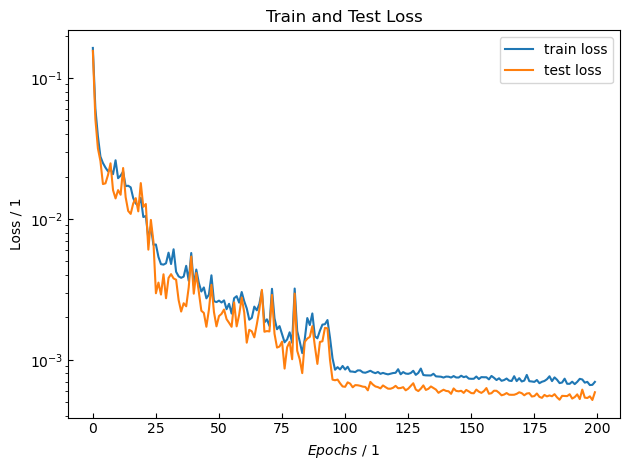

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998104041919014 , R^2(NH3) = 0.9987798171921981
Test Dataset: R^2(H2) = 0.999744631218497 , R^2(NH3) = 0.9991366933676253
Max Error Training: |x_H2 - x_H2,pred| = 0.01733875756653991 , |x_NH3 - x_NH3,pred| = 0.027400785677888978
Max Error Test: |x_H2 - x_H2,pred| = 0.013404598665392176 , |x_NH3 - x_NH3,pred| = 0.014924956289100677


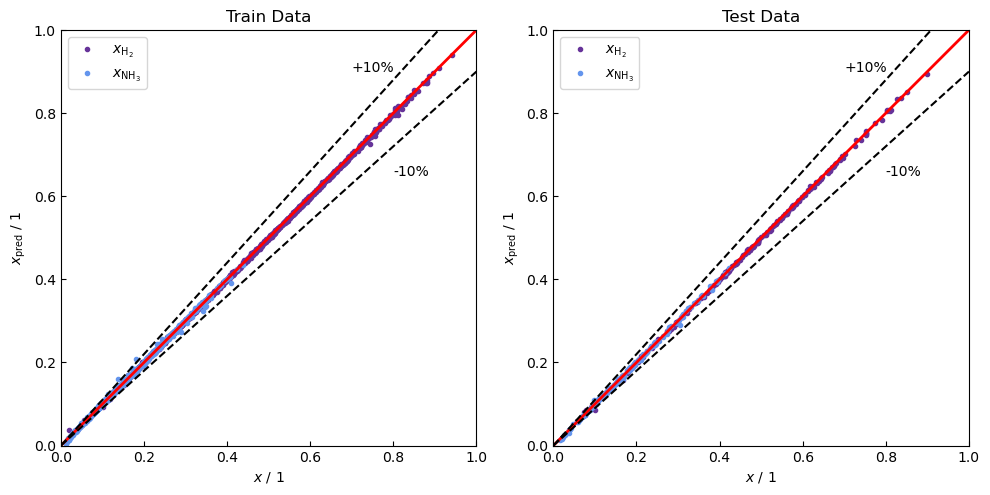

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

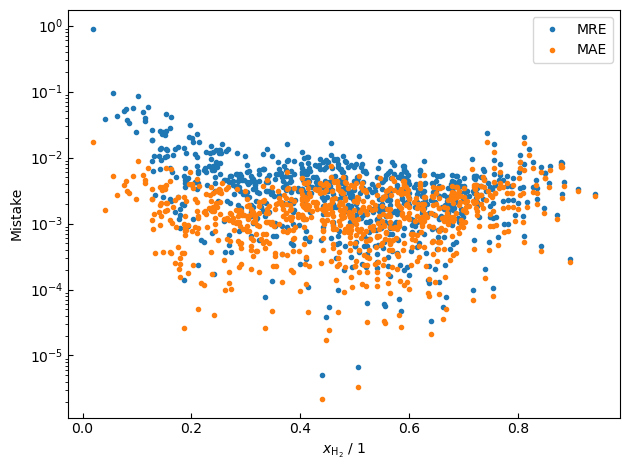

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

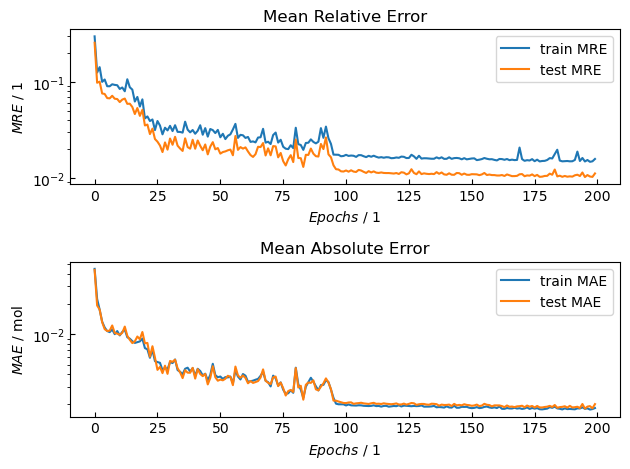

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

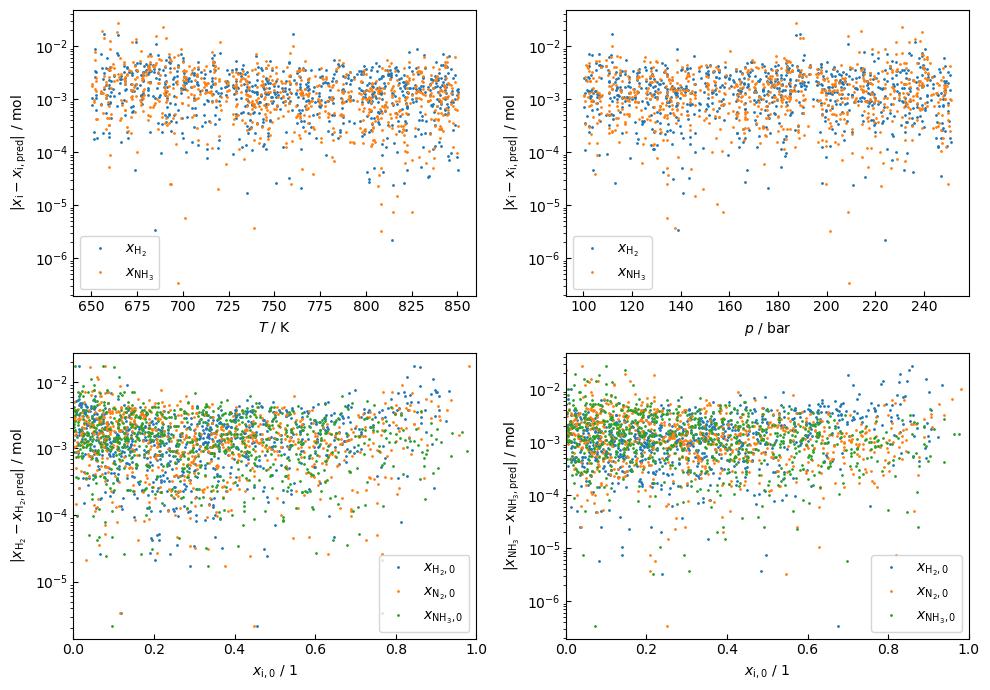

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

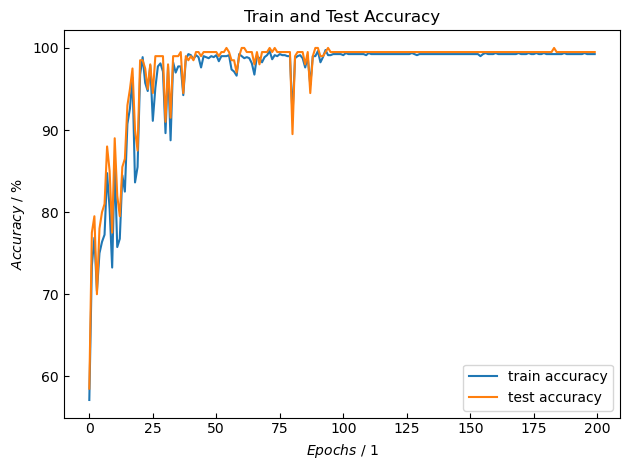

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.0 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 0.1993, -0.4285,  0.7691, -0.3588, -0.3880],
        [ 0.8410,  1.3591, -0.4616, -1.0290,  1.5048],
        [-1.7403, -0.2047, -0.7528, -0.5442,  1.2950],
        [ 1.4278, -1.5541, -0.0272, -1.1204,  1.1718],
        [-0.0608, -0.5690,  2.3399, -1.0071, -1.2670],
        [-1.1078, -0.8561, -1.0311, -0.6215,  1.6471],
        [ 0.1381, -0.7541,  0.6634, -1.2862,  0.6636],
        [ 0.5370,  0.8201,  0.4321, -0.2713, -0.1468],
        [-0.6698,  1.0401,  2.1113, -1.1116, -0.9358],
        [ 1.5672, -1.6738, -1.0385, -0.7622,  1.7982],
        [-1.3957,  1.3427,  0.3422,  0.4550, -0.8009],
        [ 0.0939, -0.9943, -1.2815,  0.6239,  0.6200],
        [ 0.2587,  1.2944,  0.7943,  0.1553, -0.9383],
        [-1.3154, -1.2227,  0.5924, -1.0401,  0.4816],
        [-0.2625,  0.6533, -1.1120,  1.4726, -0.4138],
        [-1.3302, -0.9493,  0.2681, -1.2327,  0.9968],
        [-1.3690, -0.5561, -1.3195, -0.1100,  1.4074],
        [ 0.1488,  1.3283, -0.6408,  1.3340, -0.7346],
        [-

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.3157, -0.2908,  0.1089,  0.1255, -0.0384],
         [-0.0894, -0.3066,  0.3586,  0.2714,  0.5149],
         [ 0.1918, -0.2248,  0.0060, -0.2081,  0.0655],
         [ 0.1942, -0.2288,  0.0210,  0.0577,  0.1197],
         [ 0.1387, -0.1532,  0.3379,  0.4619, -0.0736],
         [ 0.0366,  0.1638, -0.1918,  0.4296, -0.3695],
         [-0.1984, -0.2303,  0.5256,  0.0719,  0.4311],
         [ 0.1285, -0.2472,  0.1596,  0.0814,  0.2630],
         [ 0.3959,  0.2446, -0.0961, -0.0138,  0.3186],
         [ 0.2593,  0.1402, -0.2106,  0.1600, -0.1062],
         [ 0.1475, -0.1181, -0.5583,  0.1451,  0.2773],
         [ 0.0388,  0.1057,  0.5700,  0.0650,  0.0366],
         [-0.5547,  0.3049, -0.3078,  0.5389, -0.1057],
         [-0.0622, -0.0727,  0.1459,  0.1554,  0.0504],
         [-0.5610,  0.0181,  0.1966,  0.0753,  0.3633],
         [-0.2072,  0.0239,  0.0050, -0.2755,  0.1399],
         [ 0.2686,  0.3168,  0.2677,  0.1309, -0.2366],
         [-0.4994, -0.053

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.3040, 0.8497, 0.2093, 0.8127, 0.4791],
        [0.6122, 0.2517, 0.6711, 0.6744, 0.8066]])
tensor([[-0.2205, -0.0585],
        [ 0.2463, -0.3895]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.5181e+00, -1.1482e+00, -1.0569e+00,  1.9644e+00, -9.7054e-01],
        [-1.1109e+00, -5.5717e-01, -1.2407e+00,  2.2930e+00, -1.1260e+00],
        [-1.6934e-01,  1.4109e+00, -4.8632e-01, -1.1455e+00,  1.6481e+00],
        [-1.7582e+00, -8.4388e-01, -8.6370e-01,  1.9956e+00, -1.1920e+00],
        [-3.6225e-01,  1.6103e+00, -6.8104e-01, -5.9348e-01,  1.2749e+00],
        [-1.0200e+00, -1.6840e+00,  5.8836e-01, -7.5977e-01,  1.9913e-01],
        [ 1.4779e+00,  1.0717e-01, -4.8628e-01, -1.2151e+00,  1.7192e+00],
        [-9.2684e-01, -3.0862e-01, -6.7408e-01,  1.1812e+00, -5.4571e-01],
        [ 1.0040e+00, -1.4843e+00, -4.6744e-01,  1.1420e+00, -7.0849e-01],
        [-2.6726e-01,  6.2918e-01,  1.2525e+00, -5.3543e-01, -6.8194e-01],
        [ 9.3939e-02, -9.9426e-01, -1.2815e+00,  6.2394e-01,  6.1997e-01],
        [-1.1362e+00, -1.1689e+00, -5.0226e-01,  3.1843e-01,  1.6746e-01],
        [-3.1770e-01,  9.9440e-01, -1.2310e+00,  8.1979e-01,  3.7017e-01],
        [ 1.2847e-01, -1.

#### Histogramme Verteilung von $xi$ und $x{_i}$

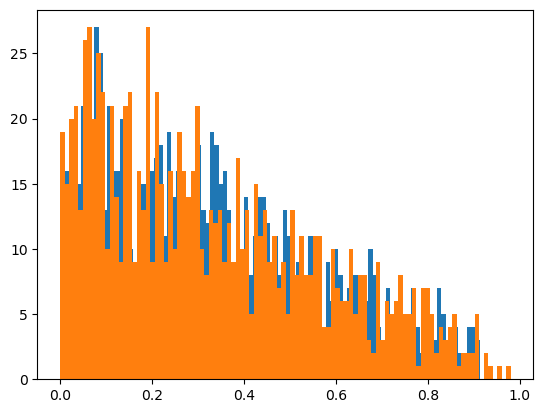

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_025.pth')
# np.savez('data/models/params_005_025.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)